# The Ultimate Data Challenge

In [247]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

## Part 1: Exploratory Data Analysis (EDA)
EDA is implemented on the timestamps data of user logins to identify importance features of user demand, such as daily cycles.

In [6]:
# load the json data
with open ('logins.json', 'r') as loginsfile:
    logins = json.load(loginsfile)
logins.keys()

dict_keys(['login_time'])

In [18]:
# check how many logins in the data
print(f"There are {len(logins['login_time']):,.0f} timestamps of user logins in the data.")
logins['login_time'][:5]

There are 93,142 timestamps of user logins in the data.


['1970-01-01 20:13:18',
 '1970-01-01 20:16:10',
 '1970-01-01 20:16:37',
 '1970-01-01 20:16:36',
 '1970-01-01 20:26:21']

**Note: The timestamps started from 1970-01-01 which doesn't look right. The data should not be that old. There could be some conversion mistakes.**

In [63]:
# create a datafram for the input data
df_logins = pd.DataFrame(logins)
df_logins['login_time'] = pd.to_datetime(df_logins['login_time'])
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [64]:
# check for data type and missing data
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


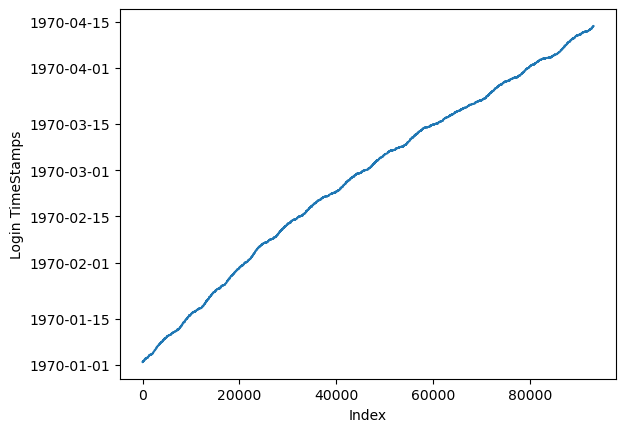

In [61]:
# plot the raw data
df_logins['login_time'].plot()
plt.xlabel('Index')
plt.ylabel('Login TimeStamps')
plt.show()

**Note:** The timestamps were generally in a increasing order.

In [65]:
# # create a col with just the login time without date
df_logins['time'] = df_logins['login_time'].dt.time
df_logins.head()

,login_time,time
0,1970-01-01 20:13:18,20:13:18
1,1970-01-01 20:16:10,20:16:10
2,1970-01-01 20:16:37,20:16:37
3,1970-01-01 20:16:36,20:16:36
4,1970-01-01 20:26:21,20:26:21


**In order to analyze the daily login patterns by 15min interval, need to calculate the minutes difference between each login and its midnight.**

Then create bins for 15min daily intervals.

In [84]:
# calculate the time difference in minutes between each login and its midnight
for i in range(df_logins.shape[0]):
    current = str(df_logins.loc[i, 'time']).split(':')
    from_midnight_s = int(current[0])*60*60 + int(current[1])*60 + int(current[2])
    df_logins.loc[i, 'away_from_midnight_m'] = from_midnight_s/(60)
df_logins.head()

,login_time,time,away_from_midnight_m
0,1970-01-01 20:13:18,20:13:18,1213.300000
1,1970-01-01 20:16:10,20:16:10,1216.166667
2,1970-01-01 20:16:37,20:16:37,1216.616667
3,1970-01-01 20:16:36,20:16:36,1216.600000
4,1970-01-01 20:26:21,20:26:21,1226.350000


In [85]:
# check if the calculations were done correctly
df_logins.describe()

,away_from_midnight_m
count,93142.000000
mean,728.417154
std,469.766574
min,0.000000
25%,244.533333
50%,748.966667
75%,1184.762500
max,1439.983333


In [86]:
# create bins and labels based on 15min time interval
bins = [15*x for x in range(24*4+1)]
labels = [x for x in range(1, 24*4+1)]
len(labels), len(bins)

(96, 97)

In [87]:
df_logins['15min_interval'] = pd.cut(df_logins['away_from_midnight_m'], bins = bins, labels = labels)
df_logins.head()

,login_time,time,away_from_midnight_m,15min_interval
0,1970-01-01 20:13:18,20:13:18,1213.300000,81
1,1970-01-01 20:16:10,20:16:10,1216.166667,82
2,1970-01-01 20:16:37,20:16:37,1216.616667,82
3,1970-01-01 20:16:36,20:16:36,1216.600000,82
4,1970-01-01 20:26:21,20:26:21,1226.350000,82


In [89]:
# check the count of each 15min interval
df_logins['15min_interval'].value_counts()

91    1682
7     1676
90    1654
92    1641
89    1634
      ... 
28     215
31     192
33     190
34     179
32     176
Name: 15min_interval, Length: 96, dtype: int64

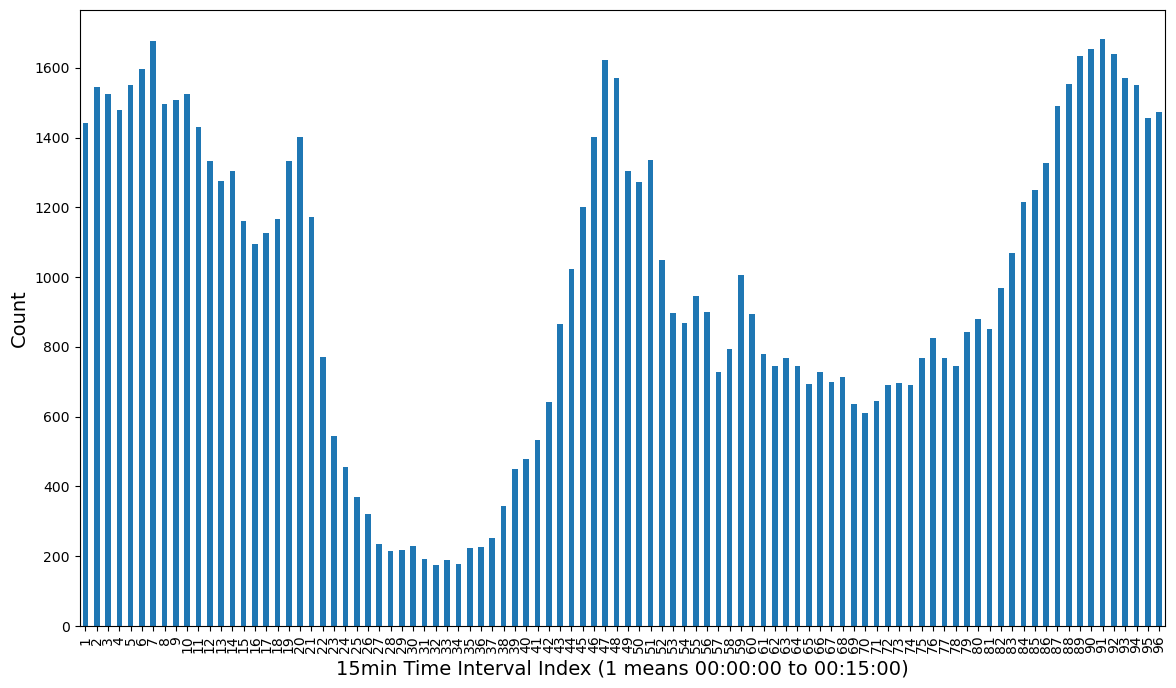

In [99]:
# plot the aggregated logins based on 15min time intervals
plt.figure(figsize = (14, 8))
df_logins['15min_interval'].value_counts().sort_index().plot(kind = 'bar')
plt.grid(False)
plt.xlabel('15min Time Interval Index (1 means 00:00:00 to 00:15:00)', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

**Summary:**
* clear daily cycles were observed based on the counts of user logins at different time interval of the data.
* Users were **very active** during the following time periods of the day:
    * 20:45 to 05:15
    * 11:00 to 12:30
* Users were **active** for:
    * 12:30 to 20:45
* Users were **not active** for:
    * 05:15 to 11:00
* The time period with the most user logins was 22:30 to 22:45.
* The time period with the least user logins was to 19:45 to 20:00.

<span style='color:red'>**Were the timestamps recorded correctly??**</span>

* The data started on 1970-01-01 which doesn't look right. Should not be that old.
* Could be related to mistakes when converting the raw timestamps to current ones.
* Usually the raw timestamps are stored as time intervals from a reference date, '1970-01-01 00:00:00' if Unix timestamp used.
* The daily cycles are true to be considered.
* But the exact time period of the day for "active" and "inactive" can be questionable.

## Part 3: Predictive Modeling

### 3.1. Data Wrangling and EDA

In [105]:
# get the input data
with open ('ultimate_data_challenge.json', 'r') as loginsfile:
    users = json.load(loginsfile)
print(f"There are {len(users)} users in the data.")

There are 50000 users in the data.


In [108]:
# create dataframe
df_users = pd.DataFrame(users)
df_users.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [109]:
# check for datatype and missing values
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### 3.1.1. Missing Data

There are missing data for `avg_rating_of_driver`, `phone` and `avg_rating_by_driver`.

For the upcoming modeling part, the missing data need to be addressed.
* For this work, rows with missing data can be dropped.
* Although the drop will be ~17% of the total data, but the total number of data is 50,000, which is sufficent for modeling even after the drop.

In [115]:
# drop missing data
df_users = df_users.dropna()
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   signup_date             41445 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               41445 non-null  float64
 5   last_trip_date          41445 non-null  object 
 6   phone                   41445 non-null  object 
 7   surge_pct               41445 non-null  float64
 8   ultimate_black_user     41445 non-null  bool   
 9   weekday_pct             41445 non-null  float64
 10  avg_dist                41445 non-null  float64
 11  avg_rating_by_driver    41445 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


In [116]:
# reset index after dropping
df_users.reset_index(drop = True, inplace = True)
df_users.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
41440,Astapor,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7
41441,Astapor,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5
41442,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
41443,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
41444,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


### 3.1.2. Retention Labels
A user is considered as retained if he/she was “active” (i.e. took a trip) in the preceding 30 days.

However, the reference date for the preceding 30 days was not provided.

In this work, the reference date was assumed to be the latest `last_trip_date` in the data.

In [126]:
# find the latest last trip date 
df_users['last_trip_date'] = pd.to_datetime(df_users['last_trip_date'])
ref_date = max(df_users['last_trip_date'])
threshold = ref_date - timedelta(days = 30)
print(f"Users are retained if their last trip date was after {threshold}.")

Users are retained if their last trip date was after 2014-06-01 00:00:00.


In [128]:
# create retention labels
def create_retention(x):
    if x > threshold:
        return 1
    else:
        return 0

In [130]:
df_users['retention'] = df_users['last_trip_date'].apply(create_retention)
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


#### 3.1.3. EDA

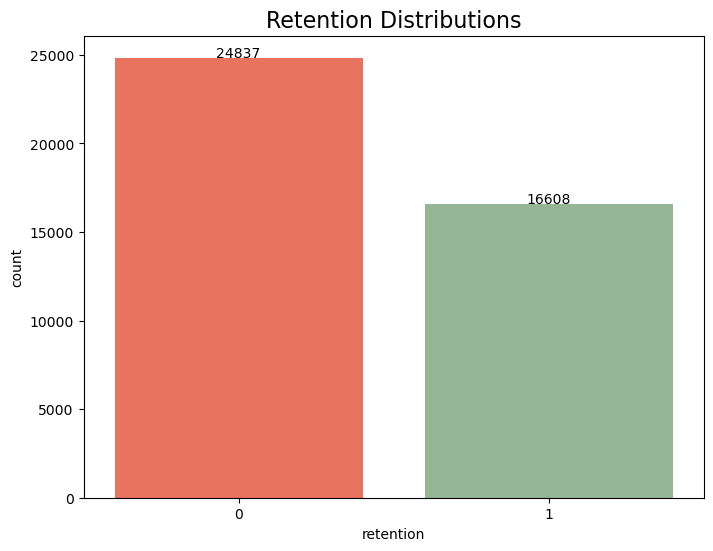

In [296]:
# check distribution of user retention
plt.figure(figsize = (8, 6))
ax = sns.countplot(data = df_users,
             x = 'retention',
             palette = {
             0: 'tomato',
             1: 'darkseagreen'})
for patch in ax.patches:
    ax.text(patch.get_x() + patch.get_width()/2,
            patch.get_height() + 10,
            int(patch.get_height()),
            ha = 'center')
plt.title('Retention Distributions', fontsize = 16)
plt.show()

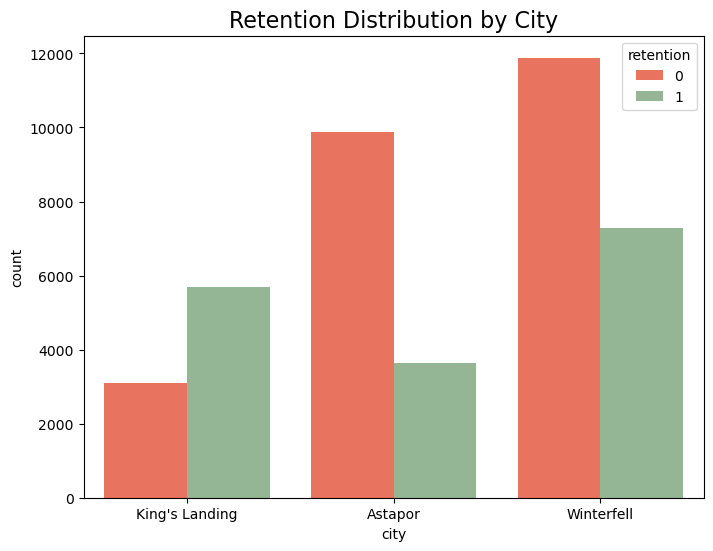

In [297]:
# check distribution of user retention based on city
plt.figure(figsize = (8, 6))
sns.countplot(data = df_users,
             x = 'city',
             hue = 'retention',
             palette = {
             0: 'tomato',
             1: 'darkseagreen'})
plt.title('Retention Distribution by City', fontsize = 16)
plt.show()

**Note:**

* User Retention distribution varied between different cities.
* Users from Astapor were more likely to leave then to be retained. 

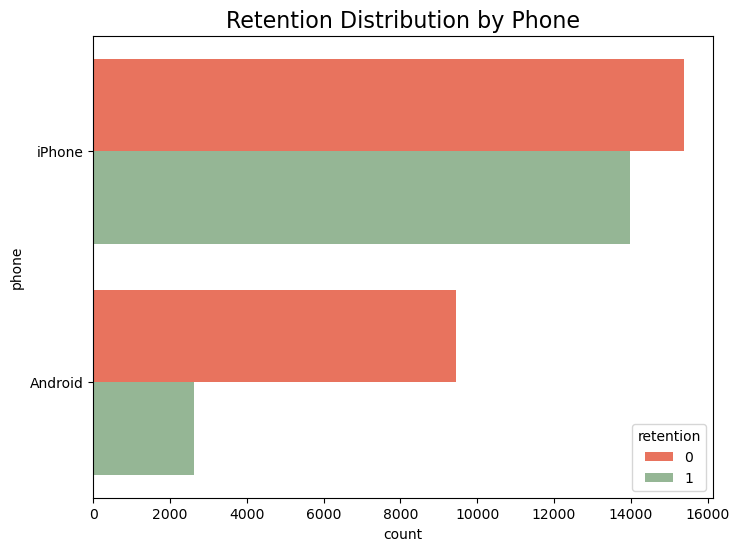

In [298]:
# check distribution of user retention based on phone type
plt.figure(figsize = (8, 6))
sns.countplot(data = df_users,
             y = 'phone',
             hue = 'retention',
             palette = {
             0: 'tomato',
             1: 'darkseagreen'})
plt.title('Retention Distribution by Phone', fontsize = 16)
plt.show()

**Note:** 

* User Retention distribution varied between iPhone and Android users.
* Android users were more likely to leave than to be retained.

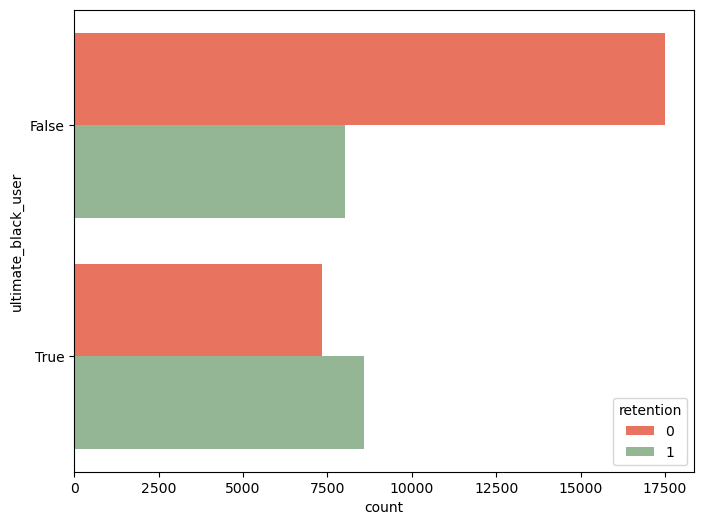

In [140]:
# check distribution of user retention based on ultimate black users
plt.figure(figsize = (8, 6))
sns.countplot(data = df_users,
             y = 'ultimate_black_user',
             hue = 'retention',
             palette = {
             0: 'tomato',
             1: 'darkseagreen'})
plt.show()

**Note:** 

* User Retention distribution varied between ultimate black users and non-ultimate black users.
* Non-ultimate black users were more likely to leave than to be retained.

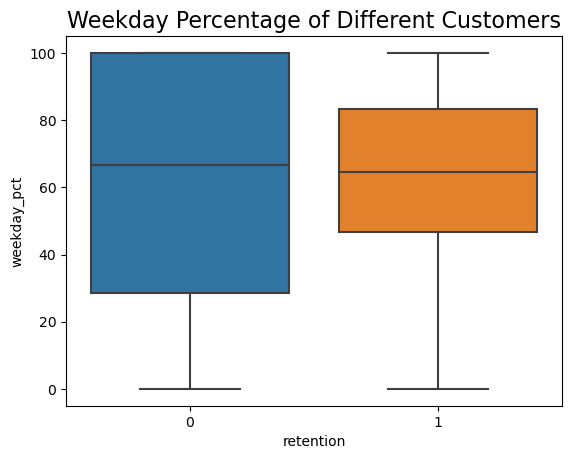

In [301]:
# check the statistics of continuous features for retained users and not-retained users
sns.boxplot(data = df_users,
           x = 'retention',
           y = 'weekday_pct')
plt.title('Weekday Percentage of Different Customers', fontsize = 16)
plt.show()

**Note:**
* The `weekday_pct` distribution was different for retained users and left users.
* The retained users had a narrowed weekeday_pct distributions.

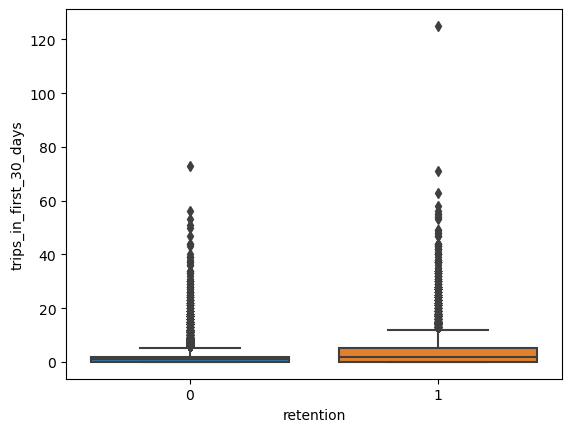

In [146]:
# check the statistics of continuous features for retained users and not-retained users
sns.boxplot(data = df_users,
           x = 'retention',
           y = 'trips_in_first_30_days')
plt.show()

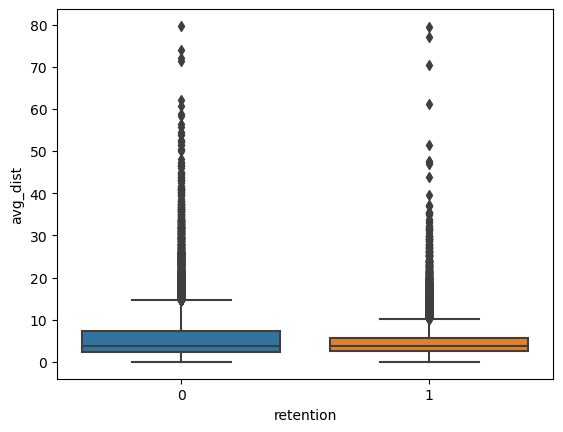

In [150]:
# check the statistics of continuous features for retained users and not-retained users
sns.boxplot(data = df_users,
           x = 'retention',
           y = 'avg_dist')
plt.show()

**Note:**
* Outliers were found for `avg_dist` and `trips_in_first_30_days`.
* But the outliers should be true data, not from mistakes.

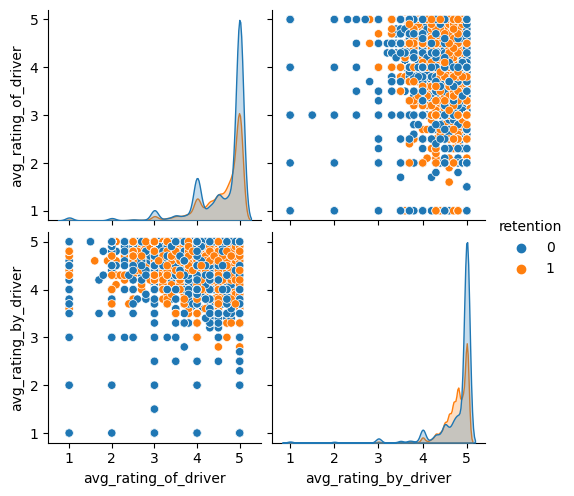

In [149]:
sns.pairplot(df_users, hue='retention', vars=['avg_rating_of_driver', 'avg_rating_by_driver'])
plt.show()

**Note:**
* `avg_rating_of_driver` was not the same as `avg_rating_by_driver`.
* The distributions of `avg_rating_of_driver` were comparable for retained users and left users.
* The distributions of `avg_rating_by_driver` were different for retained users and left users.

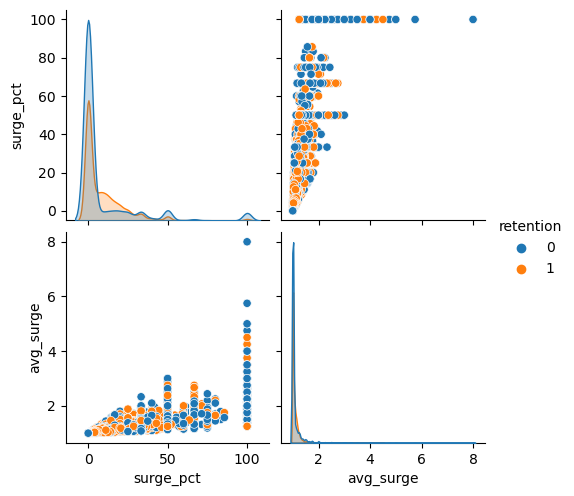

In [151]:
sns.pairplot(df_users, hue='retention', vars=['surge_pct', 'avg_surge'])
plt.show()

**Note:**
* The distributions of `surge_pct` were different for the retained users and left users.

#### 3.1.4. Numerical Features
Except for `weekday_pct`, other numerical features are skewed towards one side. 

Better to take log of those skewed distributed features.

In [251]:
# extract cols for log
num_cols = list(df_users.select_dtypes(include = ['int64', 'float64']))
num_cols.remove('weekday_pct')
num_cols.remove('retention')
num_cols

['trips_in_first_30_days',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'avg_dist',
 'avg_rating_by_driver']

In [253]:
# take the log
for col in num_cols:
    df_users[col+'_log'] = df_users[col].apply(lambda x: np.log(x) if x > 0 else 0.0001)

In [254]:
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention,trips_in_first_30_days_log,avg_rating_of_driver_log,avg_surge_log,surge_pct_log,avg_dist_log,avg_rating_by_driver_log
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,1.386294,1.547563,0.095310,2.734368,1.300192,1.609438
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,0.000100,1.609438,0.000000,0.000100,2.111425,1.609438
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,1.098612,1.458615,0.000000,0.000100,-0.261365,1.609438
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,2.197225,1.526056,0.131028,2.995732,0.858662,1.589235
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,2.639057,1.481605,0.173953,2.468100,1.141033,1.589235


#### 3.1.5. Categorical Features

In [171]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41445 entries, 0 to 41444
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41445 non-null  object        
 1   trips_in_first_30_days  41445 non-null  int64         
 2   signup_date             41445 non-null  object        
 3   avg_rating_of_driver    41445 non-null  float64       
 4   avg_surge               41445 non-null  float64       
 5   last_trip_date          41445 non-null  datetime64[ns]
 6   phone                   41445 non-null  object        
 7   surge_pct               41445 non-null  float64       
 8   ultimate_black_user     41445 non-null  bool          
 9   weekday_pct             41445 non-null  float64       
 10  avg_dist                41445 non-null  float64       
 11  avg_rating_by_driver    41445 non-null  float64       
 12  retention               41445 non-null  int64 

In [178]:
# extract categorical features
cat_cols = list(df_users.select_dtypes(include = ['object', 'bool']).columns)
cat_cols.remove('signup_date')
cat_cols

['city', 'phone', 'ultimate_black_user']

In [255]:
# use one-hot encoding with dropping
df_data = pd.get_dummies(df_users, columns = cat_cols, drop_first = True)
df_data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retention,trips_in_first_30_days_log,avg_rating_of_driver_log,avg_surge_log,surge_pct_log,avg_dist_log,avg_rating_by_driver_log,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,1.386294,1.547563,0.095310,2.734368,1.300192,1.609438,1,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0.000100,1.609438,0.000000,0.000100,2.111425,1.609438,0,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1.098612,1.458615,0.000000,0.000100,-0.261365,1.609438,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,2.197225,1.526056,0.131028,2.995732,0.858662,1.589235,1,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,2.639057,1.481605,0.173953,2.468100,1.141033,1.589235,0,1,0,0


In [256]:
# select features for modeling
df_data = df_data.drop(num_cols + ['signup_date', 'last_trip_date'], axis = 1)
df_data.head()

,weekday_pct,retention,trips_in_first_30_days_log,avg_rating_of_driver_log,avg_surge_log,surge_pct_log,avg_dist_log,avg_rating_by_driver_log,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,46.2,1,1.386294,1.547563,0.095310,2.734368,1.300192,1.609438,1,0,1,1
1,50.0,0,0.000100,1.609438,0.000000,0.000100,2.111425,1.609438,0,0,0,0
2,100.0,0,1.098612,1.458615,0.000000,0.000100,-0.261365,1.609438,0,0,1,0
3,80.0,1,2.197225,1.526056,0.131028,2.995732,0.858662,1.589235,1,0,1,1
4,82.4,0,2.639057,1.481605,0.173953,2.468100,1.141033,1.589235,0,1,0,0


## 3.2. Modeling

In order to predict if a user is retained or not in his/her 6th month after signup, a binary classification model is required. Multiple machine learning models can be used for this specific task.

Considering the need to evaluate feature importance to inform business decisions, the following 3 models should work:
* Random Forest
* Gradient Boosting Machines (XGBoost)
* Logistic Regression

In this work, **Random Forest** and **XGBoost** are used due to its ensembling learning nature and boosting nature, respectively, which can improve model performance. Both techniques are tree-based which doesn't require normalization or standarlization on the input features. 

In [257]:
# seperate feature and the target
y = df_data['retention']
X = df_data.drop('retention', axis = 1)
X.shape, y.shape

((41445, 11), (41445,))

In [258]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [259]:
X_train.shape, X_test.shape

((31083, 11), (10362, 11))

In [260]:
y_train.shape, y_test.shape

((31083,), (10362,))

#### 3.2.1. XGBoost

In [263]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [277]:
# get predictions for this model
yhat = model.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      6186
           1       0.75      0.70      0.72      4176

    accuracy                           0.78     10362
   macro avg       0.77      0.77      0.77     10362
weighted avg       0.78      0.78      0.78     10362



In [285]:
# get feature importance
xgb_fi_scores = list(model.feature_importances_)
xgb_fi = pd.DataFrame({'Feature': X_train.columns, 'Importance_Score': xgb_fi_scores})
xgb_fi = xgb_fi.sort_values(by = ['Importance_Score'], ascending = False)
xgb_fi

,Feature,Importance_Score
7,city_King's Landing,0.322899
9,phone_iPhone,0.166620
6,avg_rating_by_driver_log,0.158770
10,ultimate_black_user_True,0.092167
4,surge_pct_log,0.049267
0,weekday_pct,0.046589
3,avg_surge_log,0.045579
8,city_Winterfell,0.039188
1,trips_in_first_30_days_log,0.030429
2,avg_rating_of_driver_log,0.026838


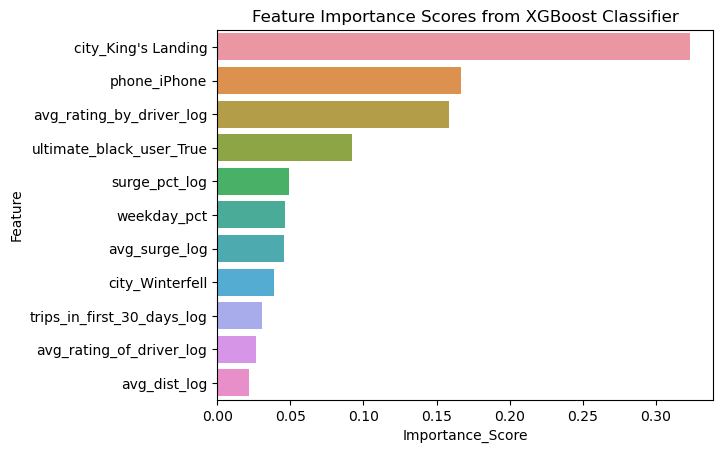

In [286]:
# plot the feature importance
sns.barplot(
    data = xgb_fi,
    y = 'Feature',
    x = 'Importance_Score'
)
plt.title('Feature Importance Scores from XGBoost Classifier', fontsize = 12)
plt.show()

#### 3.2.2. Random Forest

In [267]:
# Creating the model
rf = RandomForestClassifier(random_state=42)

In [268]:
# define parameters for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [270]:
# define GridSearchCV
rfcv = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 5,
    n_jobs = 1,
    scoring = 'accuracy'
)

In [271]:
# perform parameter tuning and fiting
rfcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [272]:
# print best parameters and best score
print("Best Parameters:", rfcv.best_params_)
print("Best Score:", rfcv.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.7813596587925042


In [273]:
# get the best model
best_rf = rfcv.best_estimator_

In [274]:
# make predictions with the best model
y_pred = best_rf.predict(X_test)
y_pred[:5]

array([1, 0, 1, 0, 1], dtype=int64)

In [275]:
# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7798687512063308
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      6186
           1       0.75      0.69      0.72      4176

    accuracy                           0.78     10362
   macro avg       0.77      0.76      0.77     10362
weighted avg       0.78      0.78      0.78     10362



In [287]:
# get feature importance
rf_fi_scores = list(best_rf.feature_importances_)
rf_fi = pd.DataFrame({'Feature': X_train.columns, 'Importance_Score': rf_fi_scores})
rf_fi = rf_fi.sort_values(by = ['Importance_Score'], ascending = False)
rf_fi

,Feature,Importance_Score
6,avg_rating_by_driver_log,0.192607
7,city_King's Landing,0.145855
4,surge_pct_log,0.128695
0,weekday_pct,0.112686
3,avg_surge_log,0.105459
9,phone_iPhone,0.080809
10,ultimate_black_user_True,0.071348
5,avg_dist_log,0.059747
1,trips_in_first_30_days_log,0.046719
2,avg_rating_of_driver_log,0.041915


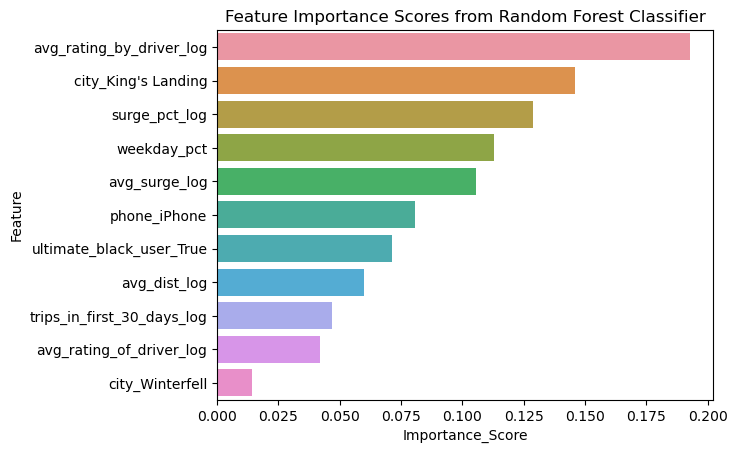

In [288]:
# plot the feature importance
sns.barplot(
    data = rf_fi,
    y = 'Feature',
    x = 'Importance_Score'
)
plt.title('Feature Importance Scores from Random Forest Classifier', fontsize = 12)
plt.show()

### 3.3. Improve Long-term Customer Retention

Based on the importance score of each feature form the two models, the following features play more important role determinig if a customer is retained or not:
* `city`
* `phone`
* `ultimate_black_user`
* `avg_rating_by_driver`
* `surge_pct and avg_surge`
* `weekday_pct`

Some recommendations can be made to improve long-term customer retention for Ultimate.

**city**

* Consider to increase the marketing or promotions in King's Landing to attract more customers since there are better chances they will be retained.
* Research why King's Landing behaves differently from other cities for potential strategies to improve retention rates in other cities.

**phone**

* Investigate the difference between the app design on iPhone and on Android then improve app design on Android to increase Android user retention.

**ultimate black**

* Promote ultimate black to new users can help increase user retention.

**weekday use**

* Consider to offer weekday discounts to improve customer's commuting use and to increase customer retention.

**surging rate**

* Implement dynamic pricing strategy more often since the retained customers showed high acceptance on surging rates.
* Consider to increase marketing on benefits of surging rate, like more ride options and less waiting time, to attract more customers willing to take rides with surging rates.

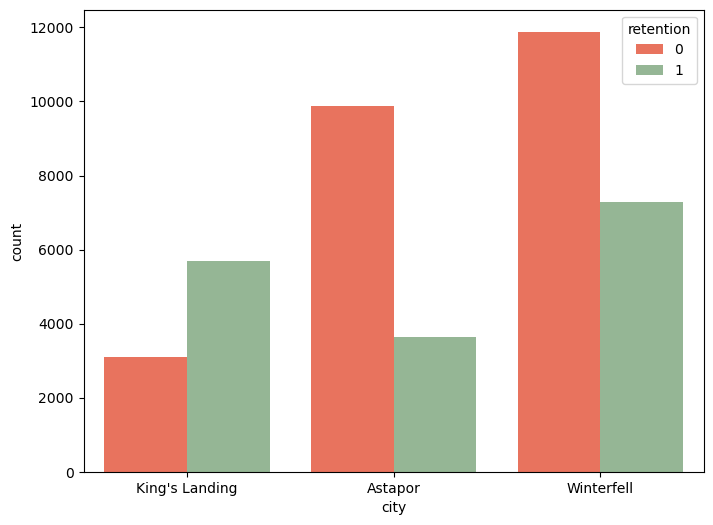

In [235]:
# check distribution of user retention based on city
plt.figure(figsize = (8, 6))
sns.countplot(data = df_users,
             x = 'city',
             hue = 'retention',
             palette = {
             0: 'tomato',
             1: 'darkseagreen'})
plt.show()

**Note:**
* Customers from King's Landing had higher retention rate.
* It is better to increase the marketing or promotions in King's Landing to attract more customers. And better chances they will be retained.
* Research why King's Landing behaves differently from other cities for potential strategies to improve retention rates in other cities.

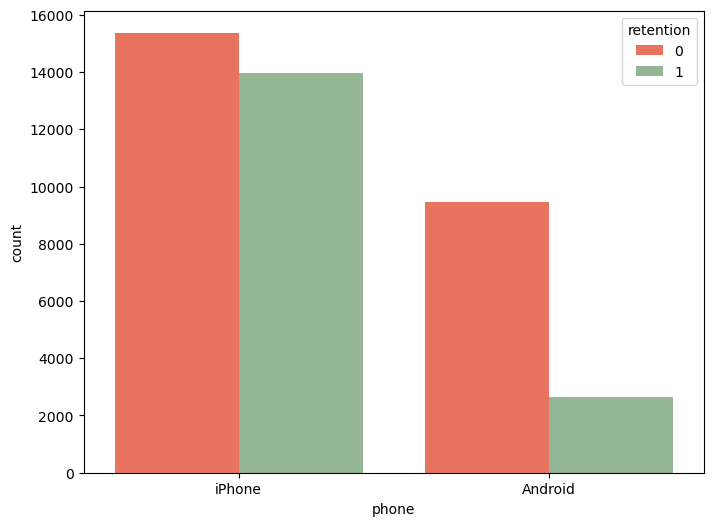

In [289]:
# check distribution of user retention based on phone
plt.figure(figsize = (8, 6))
sns.countplot(data = df_users,
             x = 'phone',
             hue = 'retention',
             palette = {
             0: 'tomato',
             1: 'darkseagreen'})
plt.show()

**Note:**
* IPhone users had higher retention rate.
* Could be related to app design. Investigate the difference between the app design on iPhone and on Android then improve app design on Android.

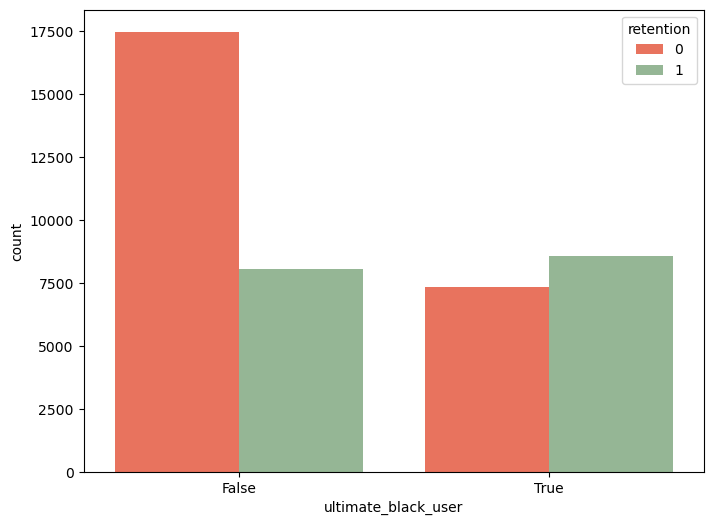

In [291]:
# check distribution of user retention based on  ultimate_black_user
plt.figure(figsize = (8, 6))
sns.countplot(data = df_users,
             x = 'ultimate_black_user',
             hue = 'retention',
             palette = {
             0: 'tomato',
             1: 'darkseagreen'})
plt.show()

**Note:**
* Customers who tried ultimate black service in the first 30 days had higher retention rate.
* Promote ultimate black to new users can help increase user retention.

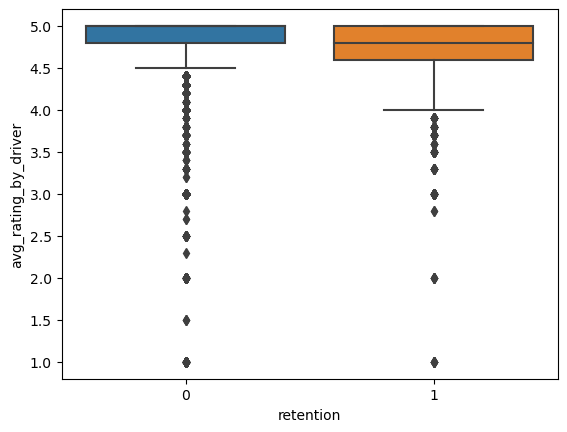

In [243]:
# check the distribution of avg_rating_by_driver for retained users and not-retained users
sns.boxplot(data = df_users,
           x = 'retention',
           y = 'avg_rating_by_driver'
          )
plt.show()

**Note:**
* `avg_rating_by_driver` is defined as the rider’s average rating over all of their trips.
* The distribution is quite different for the retained customers and non-retained customers.
* But this rating is from drivers, which is hard to control by Ultimate Technologies.

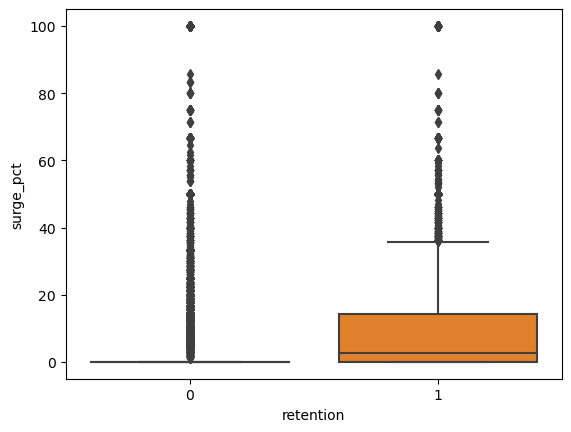

In [245]:
# check the distribution of surge_pct for retained users and not-retained users
sns.boxplot(data = df_users,
           x = 'retention',
           y = 'surge_pct'
          )
plt.show()

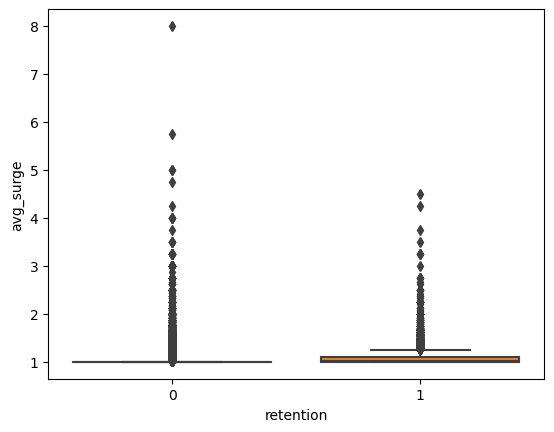

In [246]:
# check the distribution of avg_surge for retained users and not-retained users
sns.boxplot(data = df_users,
           x = 'retention',
           y = 'avg_surge'
          )
plt.show()

**Note:**
* Retained customers had higher percentage of trips taken with surging rate and higher average surging multipliers as well. 
* Therefore dynamic pricing strategy can be implemented more often. The retained customers have high acceptance on surging rates.
* Educational marketing on benefits of surging rate like more ride options and less waiting time can be implemented to attract more people to take rides with surging rates.

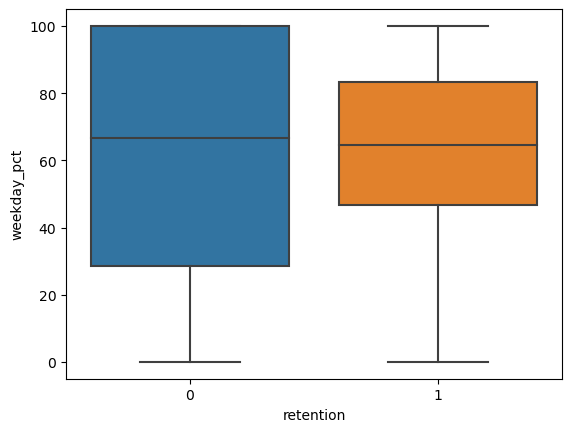

In [292]:
# check the distribution of weekday_pct for retained users and not-retained users
sns.boxplot(data = df_users,
           x = 'retention',
           y = 'weekday_pct'
          )
plt.show()

**Note:**
* The narrow distribution of weekday_pct, centered aroud 68%, indicated more regular commuting use for the majority of the retained customers. 
* Consider to offer weekday discounts to improve commuting use and to increase customer retention. 